# LM Language Metadata Visualization
- We generate the language mapping from ISO 639-1 to ISO 639-3 by scrapping `https://en.wikipedia.org/wiki/List_of_ISO_639-2_codes`, for empty ISO 693-3 code, we use the ISO 693-2 code instead
- We also generate CC language data statistics from `https://commoncrawl.github.io/cc-crawl-statistics/plots/languages` with the latest dump on the version `2013-14`
- For other language source, i.e., xP3, ROOTS, mC4, and LLaMA collection, the data is manually collected from the corresponding paper

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lang2vec.lang2vec as l2v
import umap

### Language Metadata from Wiki

In [2]:
meta_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_ISO_639-2_codes')[0]
meta_df.columns = ['639-2', '639-3', '639-5', '639-1', 'lang_name', 'scope', 'type', 'native_name', 'other_name']

In [3]:
meta_df.loc[pd.isna(meta_df['639-3']), '639-3'] = meta_df.loc[pd.isna(meta_df['639-3']), '639-2'].reset_index(drop=True)

In [4]:
meta_df[['639-1', '639-3', 'lang_name', 'native_name', 'other_name', 'scope', 'type']]

,639-1,639-3,lang_name,native_name,other_name,scope,type
0,aa,aar,Afar,Qafaraf; ’Afar Af; Afaraf; Qafar af,NaN,Individual,Living
1,ab,abk,Abkhazian,Аҧсуа бызшәа Aƥsua bızšwa; Аҧсшәа Aƥsua,Abkhaz,Individual,Living
2,NaN,ace,Achinese,بهسا اچيه,Acehnese,Individual,Living
3,NaN,ach,Acoli,Lwo,Acholi,Individual,Living
4,NaN,ada,Adangme,Dangme,Dangme,Individual,Living
...,...,...,...,...,...,...,...
482,NaN,NaN,Zande languages,NaN,NaN,Collective,NaN
483,zu,zul,Zulu,isiZulu,NaN,Individual,Living
484,NaN,zun,Zuni,Shiwi'ma,NaN,Individual,Living
485,NaN,zxx,No linguistic content; Not applicable,NaN,NaN,Special,NaN


### CC Language Source

In [5]:
cc_df = pd.read_html('https://commoncrawl.github.io/cc-crawl-statistics/plots/languages')[0]

In [6]:
cc_df.columns = ['Lang Code', cc_df.columns[1][0], cc_df.columns[2][0], cc_df.columns[3][0]]

In [7]:
# Gathered manually from https://iso639-3.sil.org/code_tables/639/data
cc_unk_lang_map = {
    'bih': 'Bihari languages',
    'crs': 'Seselwa Creole French',
    'lif': 'Limbu',
    'mfe': 'Morisyen',
    '<unknown>': '<unknown>'
}

In [8]:
cc_df['Lang Name'] = cc_df['Lang Code'].apply(
    lambda x: meta_df.loc[meta_df['639-3'] == x, 'lang_name'].values[0] if x in meta_df['639-3'].values else cc_unk_lang_map[x]
)
cc_df.loc[cc_df['Lang Code'] == '<unknown>', 'Lang Code'] = 'zxx'
cc_df['Source'] = 'commoncrawl'
cc_df = cc_df[['Lang Code', 'Lang Name', 'Source']]

# Normalized Other Language Source

In [9]:
dfs = [cc_df]
for path in glob.glob('language_source/*.csv'):
    df = pd.read_csv(path)
    df['Lang Code'] = df['Lang Code'].apply(
        lambda x: meta_df.loc[meta_df['639-1'] == x, '639-3'].values[0] if x in meta_df['639-1'].values else x
    )
    df['Source'] = path.split('/')[-1].split('_lang')[0]
    dfs.append(df)
df = pd.concat(dfs)

In [10]:
df

,Lang Code,Lang Name,Source
0,zxx,<unknown>,commoncrawl
1,aar,Afar,commoncrawl
2,abk,Abkhazian,commoncrawl
3,afr,Afrikaans,commoncrawl
4,aka,Akan,commoncrawl
...,...,...,...
15,rus,Russian,llama_collection
16,slv,Slovenian,llama_collection
17,srp,Serbian,llama_collection
18,swe,Swedish,llama_collection


In [11]:
unique_lang_code = df['Lang Code'].unique()

### Retrieve Features from URIEL

In [12]:
%%time
# features = [
#     'syntax_wals', 'syntax_sswl', 'syntax_ethnologue', 'syntax_knn', 'syntax_average', 
#     'phonology_wals', 'phonology_average', 'phonology_ethnologue', 'fam', 'geo'
# ]

# features = ['syntax_average',  'phonology_average', 'fam', 'geo']
features = ['syntax_average', 'fam', 'geo']
# features = ['fam']
lang_feats = {lang: [] for lang in list(l2v.LANGUAGES)}

for feat in features:
    feats = l2v.get_features(list(l2v.LANGUAGES), feat)
    for lang in lang_feats.keys():
        lang_feats[lang] += feats[lang]

fdf = pd.DataFrame(lang_feats)
fdf[fdf == '--'] = np.nan # Replace '--' column with NaN
fdf = fdf.fillna(0).T # Replace NaN with 0
fdf = fdf.sort_index()
print(fdf.shape)

(4005, 4120)
CPU times: user 1min 2s, sys: 1.18 s, total: 1min 3s
Wall time: 1min 3s


In [13]:
%%time
umap_mdl = umap.UMAP(low_memory=False)
proj_values = umap_mdl.fit_transform(fdf.values)
fdf['pc1'], fdf['pc2'] = proj_values[:,0], proj_values[:,1]

CPU times: user 3min 34s, sys: 5.69 s, total: 3min 40s
Wall time: 36.9 s


In [14]:
fdf

,0,1,2,3,4,5,6,7,8,9,...,4112,4113,4114,4115,4116,4117,4118,4119,pc1,pc2
aaa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3679,0.5430,0.4293,0.4373,0.5168,0.4100,0.4808,0.4605,9.045267,15.604736
aab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3590,0.5341,0.4157,0.4302,0.5049,0.3989,0.4717,0.4499,9.227167,15.997808
aac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.6319,0.5089,0.5145,0.6094,0.4826,0.5715,0.5505,0.5442,-0.157560,-6.879316
aad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.6101,0.4885,0.4929,0.5881,0.4610,0.5496,0.5291,0.5225,-0.653633,-6.863320
aae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.2024,0.3722,0.2447,0.2799,0.3352,0.2318,0.3102,0.2838,7.151989,7.749585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ztu,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.4010,0.3553,0.4874,0.3443,0.4253,0.4305,0.3719,0.4062,13.255445,-5.222830
zty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3984,0.3535,0.4851,0.3419,0.4234,0.4281,0.3697,0.4040,13.352789,-5.479901
zul,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,1.0,0.0,...,0.5673,0.7312,0.5770,0.6445,0.6763,0.5895,0.6719,0.6407,6.030100,17.236689
zun,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.3264,0.2423,0.3881,0.2560,0.3138,0.3399,0.2691,0.3055,11.584819,-2.138388


In [15]:
fdf['category'] = fdf.index.isin(unique_lang_code)
fdf['category'] = fdf['category'].apply(lambda x: 'Supported' if x else 'Not Supported')

CPU times: user 873 ms, sys: 128 ms, total: 1 s
Wall time: 744 ms


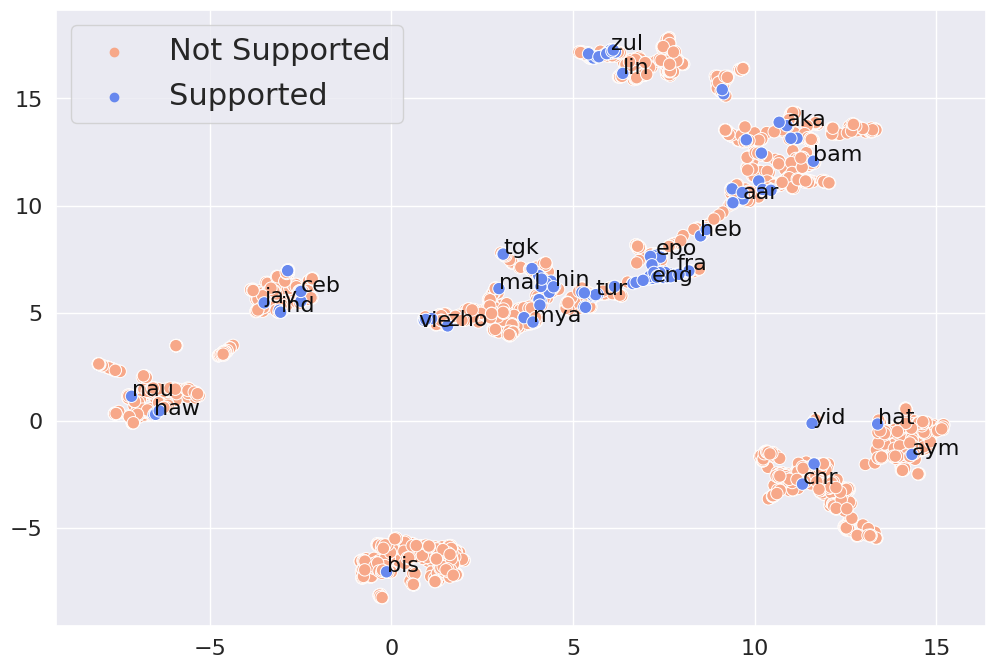

In [16]:
%%time
sns.set(rc={'figure.figsize':(12,8)})

cw_palette = sns.color_palette("coolwarm_r")
render_palette = sns.color_palette([cw_palette[1], cw_palette[-1]])
sns.scatterplot(fdf.sort_values('category'), x='pc1', y='pc2', hue='category', palette=render_palette, s=80)

def label_point(xs, ys, vals, ax):
    np.random.seed(512)
    for x, y, val in zip(xs, ys, vals):
        if val == '':
            continue

        if val == 'fra':
            ax.text(x + 0.15, y + 0.3, str(val), color='#0d0d0d', fontsize=16)
        elif val == 'eng':
            ax.text(x - 0.15, y - 0.2, str(val), color='#0d0d0d', fontsize=16)
        elif val == 'vie':
            ax.text(x - 0.15, y - 0.3, str(val), color='#0d0d0d', fontsize=16)
        else:
            ax.text(x, y, str(val), color='#0d0d0d', fontsize=16)

lang_filter = [
    'eng', 'slo', 'jap', 'zho', 'ind', 'vie', 'aka', 'mya', 'tgk', 'jav',
    'haw', 'nau', 'bis', 'chr', 'hat', 'aym', 'bam', 'aar', 'fas', 
    'yid', 'ceb', 'heb', 'hin', 'zul', 'fra', 'tur', 'epo', 'mal', 'lin',
]

lang_list = list(fdf.index)
filt_lang_list = [lang if lang in lang_filter else '' for lang in lang_list]
label_point(fdf['pc1'], fdf['pc2'], filt_lang_list, plt.gca())
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=22)
plt.savefig('LM-supported.png', bbox_inches='tight')

### Visualize Language Family 

In [17]:
fam_feats = np.load('family_features.npz')
# lang_fams = [
#     'Atlantic-Congo', 'Austronesian', 'Indo-European', 'Sino-Tibetan', 'Bookkeeping', 'Afro-Asiatic',
#     'Pama-Nyungan', 'Sign Language', 'Otomanguean', 'Austroasiatic', 'Tai-Kadai', 'Dravidian', 
#     'Guinea', 'Arawakan', 'Mande', 'Tupian', 'Nilo-Saharan', 'Eastern Sudanic', 'Turkic'
# ]
# f_lang_fams = list(map(lambda l: f'F_{l}', lang_fams))

idx2fam = {}
for i, feat in enumerate(fam_feats['feats']):
    idx2fam[i] = feat

In [18]:
%%time
fam_data = {lang: [] for lang in list(l2v.LANGUAGES)}
l2v_fam_feats = l2v.get_features(list(l2v.LANGUAGES), 'fam')
for lang in fam_data.keys():
    fam_data[lang] = np.array(l2v_fam_feats[lang])[list(idx2fam.keys())]

fam_df = pd.DataFrame(fam_data)
fam_df[fam_df == '--'] = np.nan # Replace '--' column with NaN
fam_df = fam_df.fillna(0).T # Replace NaN with 0
fam_df = fam_df.sort_index()
print(fam_df.shape)

(4005, 3718)
CPU times: user 17.4 s, sys: 636 ms, total: 18.1 s
Wall time: 18.1 s


In [19]:
fam_df.columns = idx2fam.values()
fam_count_df = fam_df.sum().reset_index()
fam_count_df.sum()

index    F_AustronesianF_Nuclear AustronesianF_Malayo-P...
0                                                  21773.0
dtype: object

In [20]:
lang_fam_priority = fam_count_df.sort_values(0, ascending=False)['index'].tolist()
lang_idx_priority = fam_count_df.sort_values(0, ascending=False).index.tolist()

In [21]:
%%time
lang_family_map = {'lang': [], 'fam': []}
for lang in l2v_fam_feats.keys():
    feats = l2v_fam_feats[lang]
    for idx, fam in zip(lang_idx_priority, lang_fam_priority):
        if feats[idx] > 0:
            lang_family_map['lang'].append(lang)
            lang_family_map['fam'].append(fam)
            break

CPU times: user 302 ms, sys: 0 ns, total: 302 ms
Wall time: 301 ms


In [22]:
cdf = pd.DataFrame({'count': lang_family_map['fam']}).groupby('count').size().sort_values(ascending=False)

In [23]:
cdf[cdf > 100].shape, cdf[cdf > 100].sum()

((7,), 2204)

In [24]:
cdf[(cdf >= 10) & (cdf < 100)].shape, cdf[(cdf >= 10) & (cdf < 100)].sum()

((37,), 984)

In [25]:
cdf[cdf < 10].shape, cdf[cdf < 10].sum()

((175,), 543)

In [157]:
more40_fams = cdf[(cdf >= 40)].index.tolist()
less40_fams = cdf[(cdf >= 10) & (cdf < 40)].index.tolist()
less10_fams = cdf[(cdf < 10)].index.tolist()

In [158]:
def group_family(fam):
    # if fam in more40_fams:
    #     return fam
    # elif fam in less40_fams:
    #     return 'F_Others'
    if fam in less10_fams:
        return 'F_Others'
    elif fam[2:] in ['Afro-Asiatic', 'Abkhaz-Adyge', 'Indo-European', 'Atlantic-Congo',
       'Aymara', 'Turkic', 'Mande', 'Sino-Tibetan', 'Austronesian',
       'Iroquoian', 'Artificial Language', 'Uralic', 'Japonic',
       'Eskimo-Aleut', 'Dravidian', 'Kartvelian', 'Austroasiatic',
       'Koreanic', 'Tai-Kadai']:
        return fam
    else:
        return 'F_Others'

ldf = pd.DataFrame(lang_family_map)
ldf['fam_group'] = ldf['fam'].apply(group_family)
ldf = ldf.set_index('lang')

In [159]:
lf_df = fdf.merge(ldf, left_index=True, right_index=True)

In [180]:
lf_df[['pc1', 'pc2', 'category', 'fam', 'fam_group']].to_csv('raw_language_family_data.csv')

/tmp/ipykernel_12001/594715099.py:20: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_12001/594715099.py:21: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



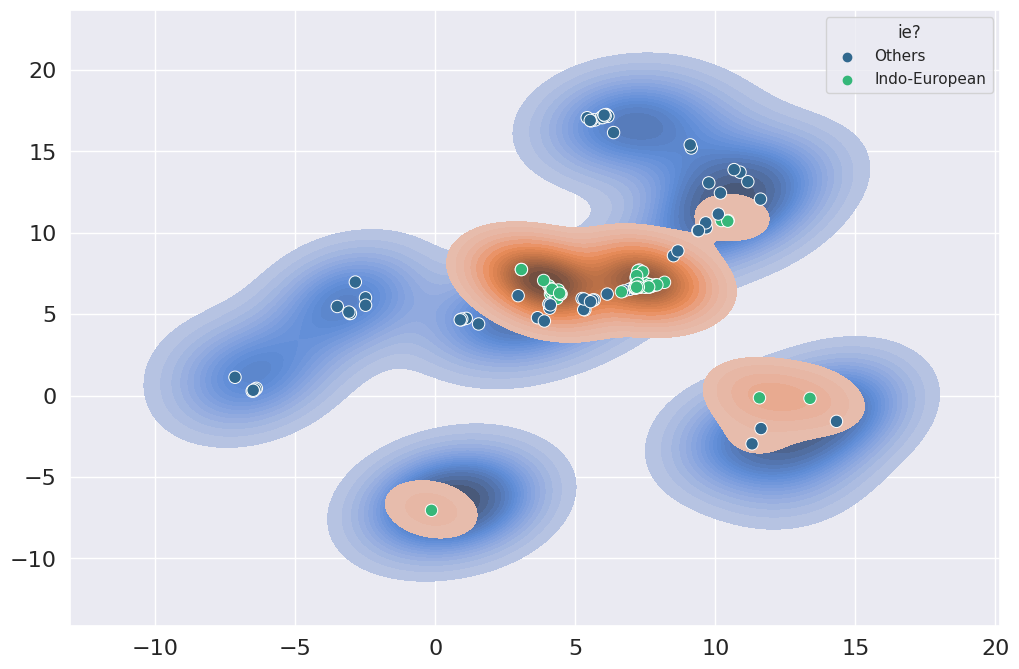

In [160]:
plf_df = lf_df.copy()
plf_df['fam_group'] = plf_df['fam_group'].apply(lambda x: x[2:])

def label_point(xs, ys, vals, ax):
    np.random.seed(512)
    for x, y, val in zip(xs, ys, vals):
        if val == '':
            continue

        if val == 'fra':
            ax.text(x + 0.15, y + 0.3, str(val), color='#0d0d0d', fontsize=16)
        elif val == 'eng':
            ax.text(x - 0.15, y - 0.2, str(val), color='#0d0d0d', fontsize=16)
        elif val == 'vie':
            ax.text(x - 0.15, y - 0.3, str(val), color='#0d0d0d', fontsize=16)
        else:
            ax.text(x, y, str(val), color='#0d0d0d', fontsize=16)
            
# for fam_group in lf_df['fam_group'].unique():
sns.kdeplot(plf_df.loc[plf_df['fam_group'] != 'Indo-European'], x='pc1', y='pc2', palette="Blues", fill=True, levels=20)
sns.kdeplot(plf_df.loc[plf_df['fam_group'] == 'Indo-European'], x='pc1', y='pc2', palette="Reds", fill=True, levels=20)

plf_df['ie?'] = plf_df['fam_group'].apply(lambda x: 'Indo-European' if x == 'Indo-European' else 'Others')
sns.scatterplot(plf_df.loc[plf_df['category'] == 'Supported'], x='pc1', y='pc2', hue="ie?", palette='viridis', s=80)

# lang_filter = list(fdf.loc[fdf['category'] == 'Supported',:].index)

plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
# plt.legend(fontsize=22)
# plt.xlim((-9, 18))
# plt.ylim((-8, 20))

lang_list = list(fdf.index)
filt_lang_list = [lang if lang in lang_filter else '' for lang in lang_list]
# label_point(fdf['pc1'], fdf['pc2'], filt_lang_list, plt.gca())

In [161]:
fc_df = plf_df.groupby(['fam_group', 'category']).size().reset_index()
sfc_df = fc_df.groupby('fam_group')[0].sum().reset_index()
sfc_df.columns = ['fam_group', 'sum']
fc_df = fc_df.merge(sfc_df, on='fam_group')
fc_df['percent'] = fc_df[0] / fc_df['sum']

In [167]:
fc_df.loc[fc_df['category'] == 'Supported',:].sort_values('percent', ascending=False)

,fam_group,category,0,sum,percent
13,Indo-European,Supported,65,272,0.238971
23,Turkic,Supported,7,35,0.200000
25,Uralic,Supported,3,25,0.120000
9,Dravidian,Supported,4,38,0.105263
11,Eskimo-Aleut,Supported,1,11,0.090909
21,Tai-Kadai,Supported,2,27,0.074074
5,Austroasiatic,Supported,3,66,0.045455
1,Afro-Asiatic,Supported,7,186,0.037634
3,Atlantic-Congo,Supported,21,671,0.031297
7,Austronesian,Supported,14,604,0.023179


In [168]:
fam_order = {
    'Indo-European': 0,
    'Turkic': 1,
    'Uralic': 2,
    'Dravidian': 3,
    'Eskimo-Aleut': 4,
    'Tai-Kadai': 5,
    'Austroasiatic': 6,
    'Afro-Asiatic': 7,
    'Atlantic-Congo': 8,
    'Austronesian': 9,
    'Mande': 10,
    'Sino-Tibetan': 11,
    'Others': 12
}
fc_df['fam_order'] = fc_df['fam_group'].apply(lambda x: fam_order[x])

In [171]:
fc_df['text'] = fc_df.apply(lambda x: f'{x[0]} ({x["percent"] * 100:.2f}%)' if x['category'] != 'Supported' else f'{x[0]}', axis='columns')

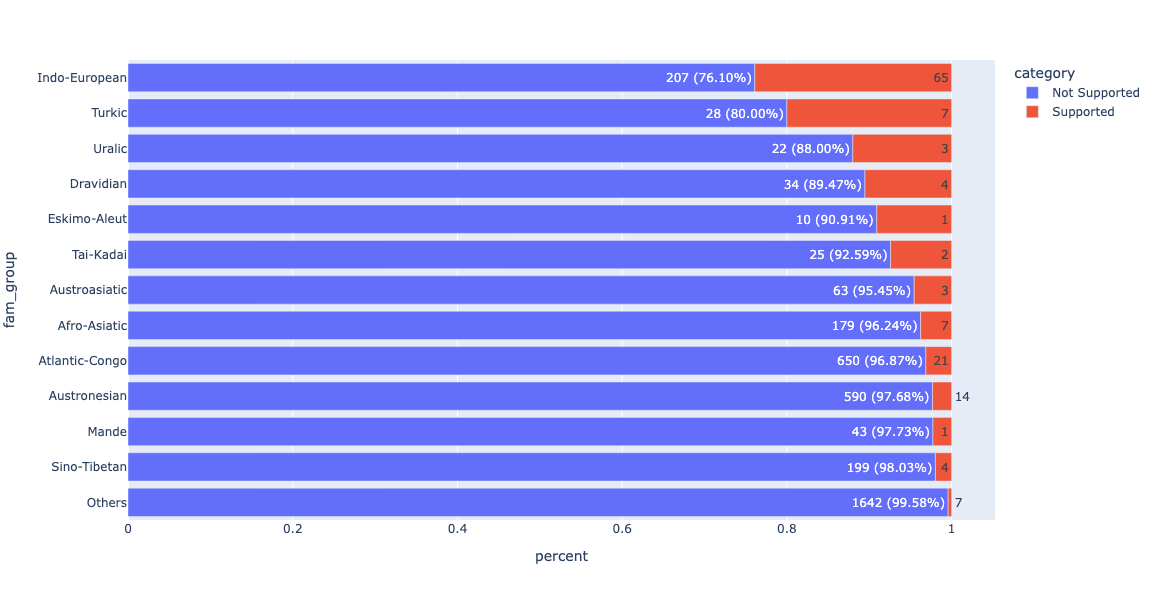

In [172]:
import plotly.express as px

fig = px.bar(
    fc_df.sort_values(['category', 'fam_order'], ascending=[True, False]), 
y="fam_group", x='percent', color="category", text="text", width=600, height=600)
fig.show()

In [177]:
fc_df.to_csv('aggregate_lang_fam_data.csv')

In [67]:
fc_df.sort_values(['category','fam_group', 'percent'], ascending=[False, True, False])

,fam_group,category,0,sum,percent
1,Afro-Asiatic,Supported,7,186,0.037634
4,Atlantic-Congo,Supported,21,671,0.031297
6,Austroasiatic,Supported,3,66,0.045455
8,Austronesian,Supported,14,604,0.023179
10,Indo-European,Supported,65,272,0.238971
12,Mande,Supported,1,44,0.022727
15,Others,Supported,24,1210,0.019835
20,Sino-Tibetan,Supported,4,203,0.019704
0,Afro-Asiatic,Not Supported,179,186,0.962366
2,Arawakan,Not Supported,49,49,1.000000
